## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt

## Printing
Those functions were used to view data, textual and graphic, and were essential to debbugging and writing the algorithms below

In [2]:
def PrintSortDict(sd):
    for k in sd.keys():
        print(f"{k}: {sd[k]}")

def PrintKeys(sd):
    for k in sd.keys():
        print(f"{k}; ")

def PrintScope(sd):
    for k in sd.keys():
        print(f"Vizinhos de {k.id}: ")
        for kk in sd[k].keys():
            print(f"{kk.id}: {sd[k][kk]}")

In [3]:
def PrintHullA(polar_hull):
    x = []
    y = []
    for key in polar_hull.keys():
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])
    plt.plot(x, y, marker='o', color='b')

def PrintPoints(rb):
    x = []
    y = []
    for k in rb.keys():
        x.append(k.x)
        y.append(k.y)
    plt.scatter(x,y)

def PrintHullsAndSeparator(ph_one,ph_two,sep):
    fig, ax = plt.subplots()
    x = []
    y = []
    for key in ph_one.keys():
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])
    ax.plot(x, y, marker='o', color='b')
    x = []
    y = []
    for key in ph_two.keys():
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])
    ax.plot(x, y, marker='o', color='r')
    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()
    ax.set_ylim(y_limits)
    slope, inter = sep
    x = x_limits
    y = []
    y.append(slope*x[0]+inter)
    y.append(slope*x[1]+inter)
    ax.plot(x,y,color='g')
    

In [4]:
class Point:
    id = 1
    def __init__(self,a,b, c = 0, shake=1e-5):
        self.id = Point.id
        Point.id+=1
        shakes = np.random.uniform(-shake, shake, 2)
        self.x = a+shakes[0]
        self.y = b+shakes[1]
        self.classe = c

    def __add__(self, other):
        if isinstance(other, Point):
            return Point(self.x+other.x, self.y+other.y)
        elif isinstance(other, np.ndarray):
            return Point(self.x+other[0],self.y+other[1],shake=0)
        else:
            raise TypeError("Unsupported operand type")
        
    def __sub__(self, other):
        if isinstance(other, Point):
            return Point(self.x-other.x, self.y-other.y)
        else:
            raise TypeError("Unsupported operand type")
        
    def __truediv__(self,other):
        return Point(self.x/other,self.y/other)
        
    def __str__(self):
        return str(self.id)+": "+str(self.x)+"   "+str(self.y)
    

    def __lt__(self,other):
        if isinstance(other, Point):
            vec_prod = (self.x*other.y)-(self.y*other.x)
            if vec_prod>0:
                return True
            elif vec_prod<0 or (self.x==other.x and self.y==other.y):
                return False            
            else:
                raise Exception(f"Segments ending in {self} and {other} are parallel")
        else:
            raise TypeError("Unsupported operand type")
        
    
        
    def Shake(self,shake):
        shakes = np.random.uniform(-shake,shake,2)
        self.x+=shakes[0]
        self.y+=shakes[1]
        return self

    def Reset():
        Point.id = 1

def X_Coord(point):
    return point.x

class PointWrap:
    def __init__(self,other: Point):
        self.p = other
    
    def __lt__(self,other):
        return self.p.x < other.p.x

In [5]:
class Segment:
    id = 1
    def __init__(self,a: Point, b: Point, enforce_order=True, shake = 0):
        if b.x<a.x and enforce_order:
            temp = a
            a = b
            b = temp
        self.bgn = a.Shake(shake)
        self.end = b.Shake(shake)
        self.slope = (self.end.y-self.bgn.y)/(self.end.x-self.bgn.x)
        self.intercept = self.end.y - (self.slope * self.end.x)
        self.id = Segment.id
        Segment.id+=1
        
    
    def Y_At_X(self,x):
        return self.slope*x+self.intercept


    def Invert(self):
        temp = self.bgn
        self.bgn = self.end
        self.end = temp


    def __str__(self):
        return "Id: "+str(self.id)+"\nBegin: "+str(self.bgn.x)+"   "+str(self.bgn.y)+"\nEnd: "+str(self.end.x)+"   "+str(self.end.y)
    
    def __lt__(self,other):
        if isinstance(other, Segment):
            return self.bgn.x < other.bgn.x
        else:
            raise TypeError("Unsupported operand type")
        
    def Reset():
        Segment.id = 1

In [6]:
class LimitPoint:
    def __init__(self,p,i):
        self.point = p
        self.is_end = i

    def __lt__(self,other):
        if isinstance(other, LimitPoint):
            return self.point.x < other.point.x
        else:
            raise TypeError("Unsupported operand type")

## Primitivas

In [7]:
def Clockwise(a: Segment, b: Segment): #returns true if a is clockwise to b
    frst_seg = a.end - a.bgn
    scnd_seg = b.end - b.bgn
    vec_prod = (frst_seg.x*scnd_seg.y)-(frst_seg.y*scnd_seg.x)
    if vec_prod>0:
        return True
    elif vec_prod<0:
        return False
    else:
        print(a)
        print(b)
        raise Exception("Segments are parallel")

In [8]:
def SegmentsIntercept(a: Segment,b: Segment):
    check_one = Clockwise(a,Segment(a.bgn,b.bgn))
    check_two = Clockwise(a,Segment(a.bgn,b.end))
    if check_one==check_two:
        return False
    check_one = Clockwise(b,Segment(b.bgn,a.bgn))
    check_two = Clockwise(b,Segment(b.bgn,a.end))
    if check_one==check_two:
        return False
    return True

## Data reading and pre-processing

In [9]:
def SetTwoDimensions(df):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df)
    df_pca = pd.DataFrame(data = pca_result, columns = ['x', 'y'])
    return df_pca

In [10]:
def PreProcessData(path, tgtCol):
    df = pd.read_csv(path)
    tgtData = df.iloc[:, tgtCol]  # Save the nth column
    df = df.drop(df.columns[tgtCol], axis=1)
    df = SetTwoDimensions(df)
    df['target_data'] = tgtData
    return df

In [11]:
def ExtractPoints(df):
    rb_tree_points = SortedDict(X_Coord)
    for i in range(len(df)):
        p = Point(df.loc[i, "x"], df.loc[i, "y"], df.loc[i,"target_data"])
        rb_tree_points[p] = None
    return rb_tree_points


In [12]:
def ReadData(path, tgtCol):
    df = PreProcessData(path, tgtCol)
    rb_tree_points = ExtractPoints(df)
    return rb_tree_points


## Convex Hull

In [13]:
def get_next_key(sd, key):
    idx = sd.bisect(key)
    return sd.iloc[idx] if idx < len(sd) else sd.iloc[0]

def get_previous_key(sd, key):
    idx = sd.bisect_left(key)
    return sd.iloc[idx - 1] if idx > 0 else sd.iloc[len(sd)-1]

In [14]:
def ConvexHullA(rb_tree_points):
    #hull_points = SortedDict()
    polar_hull = SortedDict()
    p0 = (rb_tree_points.peekitem(0)[0]).p
    p1 = (rb_tree_points.peekitem(1)[0]).p
    p2 = (rb_tree_points.peekitem(2)[0]).p
    #hull_points[PointWrap(p0)] = None
    #hull_points[PointWrap(p1)] = None
    #hull_points[PointWrap(p2)] = None
    polar_hull[p0] = None
    polar_hull[p1] = None
    polar_hull[p2] = None
    it_points = [i.p for i in rb_tree_points.keys()]
    for p in it_points[3:]:
        polar_hull._setitem(p,None)
        n = len(polar_hull)
        index_cclock_comparable = (polar_hull.index(p) + 1) % n
        compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull
        searching_cclock = True


        index_clock_comparable = (polar_hull.index(p) - 1) % n
        compare_clock = polar_hull.iloc[index_clock_comparable]      #first element to search clockwise the vertex that links to p in the old hull
        searching_clock = True
        #PrintKeys(polar_hull) ###
        del polar_hull[p]
        n = len(polar_hull)
        removal = dict()
        #searching for parallel segment counter_clockwise
        #print(f"The new point is {p}")
        while searching_cclock:
            index_cclock_comparable = polar_hull.index(compare_cclock)
            #print(f"The anchor is {compare_cclock}")
            window = [(index_cclock_comparable-1)%n, (index_cclock_comparable+1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_cclock, enforce_order=False,shake=1e-5)
            seg2 = Segment(compare_cclock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)
            seg0 = Segment(compare_cclock, p, enforce_order=False, shake=1e-5)
            
            #print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2{seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                #print("Found")
                searching_cclock = False
            else:
                #print("Mark to remove:")
                #print(compare_cclock)
                removal[compare_cclock] = None
                #print("marked")
                compare_cclock = polar_hull.iloc[window[1]]

        #searching for parallel segment clockwise
        while searching_clock:
            index_clock_comparable = polar_hull.index(compare_clock)
            #print(f"The anchor is {compare_clock}")
            window = [(index_clock_comparable+1)%n, (index_clock_comparable-1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_clock, enforce_order=False,shake=1e-5)##
            seg2 = Segment(compare_clock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)##
            seg0 = Segment(compare_clock, p, enforce_order=False,shake=1e-5)
            #print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2: {seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                #print("Found")
                searching_clock = False
            else:
                #print("Mark to remove:")
                #print(compare_clock)
                removal[compare_clock] = None
                #print("marked")
                compare_clock = polar_hull.iloc[window[1]]
        #print("removal")
        for to_remove in removal:
            #print(to_remove)
            #PrintKeys(polar_hull)
            del polar_hull[to_remove]
            #print("after removal")
            #PrintKeys(polar_hull)
    
        polar_hull[p] = None
        #hull_points[p] = None
    return polar_hull

In [15]:
Point.Reset()
Segment.Reset()
rbt = SortedDict(lambda p: p.x)
#Test convex hull
p1 = Point(1,0)
p2 = Point(2,3)
p3 = Point(5,2)
p4 = Point(6,5)
p5 = Point(0,4)

rbt[p1] = None
rbt[p2] = None
rbt[p3] = None
rbt[p4] = None
rbt[p5] = None
#PrintPoints(rbt)
ph = ConvexHullA(rbt)
PrintPoints(ph)
PrintHullA(ph)

AttributeError: 'Point' object has no attribute 'p'

In [16]:
def ConvexHullA_BUG_NO_SISTEMA_ALGUEM_ME_DESCONFIGUROU(rb_tree_points):
    hull_points = SortedDict(X_Coord)
    polar_hull = SortedDict()
    p0 = rb_tree_points.peekitem(0)[0]
    p1 = rb_tree_points.peekitem(1)[0]
    p2 = rb_tree_points.peekitem(2)[0]
    hull_points[p0] = None
    hull_points[p1] = None
    hull_points[p2] = None
    polar_hull[p0] = None
    polar_hull[p1] = None
    polar_hull[p2] = None

    it_points = list(rb_tree_points.keys())
    for p in it_points[3:]:
        polar_hull[p] = None
        n = len(polar_hull)
        index_cclock_comparable = (polar_hull.index(p)+1)%n
        compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull
        searching_cclock = True


        index_clock_comparable = (polar_hull.index(p)-1)%n
        compare_clock = polar_hull.iloc[index_clock_comparable]      #first element to search clockwise the vertex that links to p in the old hull
        searching_clock = True
        PrintKeys(polar_hull) ###
        polar_hull.pop(p,0)
        n = len(polar_hull)
        removal = dict()
        #searching for parallel segment counter_clockwise
        print(f"The new point is {p}")
        while searching_cclock:
            index_cclock_comparable = polar_hull.index(compare_cclock)
            print(f"The anchor is {compare_cclock}")
            window = [(index_cclock_comparable-1)%n, (index_cclock_comparable+1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_cclock, enforce_order=False,shake=1e-5)
            seg2 = Segment(compare_cclock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)
            seg0 = Segment(compare_cclock, p, enforce_order=False, shake=1e-5)
            
            print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2{seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                print("Found")
                searching_cclock = False
            else:
                print("Mark to remove:")
                print(compare_cclock)
                removal[compare_cclock] = None
                print("marked")
                compare_cclock = polar_hull.iloc[window[1]]

        #searching for parallel segment clockwise
        while searching_clock:
            index_clock_comparable = polar_hull.index(compare_clock)
            print(f"The anchor is {compare_clock}")
            window = [(index_clock_comparable+1)%n, (index_clock_comparable-1)%n]
            seg1 = Segment(polar_hull.iloc[window[1]], compare_clock, enforce_order=False,shake=1e-5)##
            seg2 = Segment(compare_clock, polar_hull.iloc[window[0]], enforce_order=False,shake=1e-5)##
            seg0 = Segment(compare_clock, p, enforce_order=False,shake=1e-5)
            print(f"Segments:\nseg0: {seg0}\nseg1: {seg1}\nseg2: {seg2}")
            if Clockwise(seg1,seg0) != Clockwise(seg2,seg0):
                print("Found")
                searching_clock = False
            else:
                print("Mark to remove:")
                print(compare_clock)
                removal[compare_clock] = None
                print("marked")
                compare_clock = polar_hull.iloc[window[1]]
        
        print("polar")
        PrintKeys(polar_hull)

        print("cartesian")
        PrintKeys(hull_points)
        for to_remove in removal:
            polar_hull.pop(to_remove,0)

            for key in hull_points.keys(): ###key saiu de hull_points

                if key==to_remove: 
                    print(key)###Bug porque não consegue achar key em hull_points
                    hull_points.pop(key) ###Bug porque não consegue achar key em hull_points
                    
        polar_hull[p] = None
        hull_points[p] = None
    return hull_points, polar_hull

In [17]:
Point.Reset()
Segment.Reset()
rbt = SortedDict(lambda p: p.x)
#Test convex hull
p1 = Point(1,0)
p2 = Point(2,3)
p3 = Point(5,2)
p4 = Point(6,5)
p5 = Point(0,4)

rbt[p1] = None
rbt[p2] = None
rbt[p3] = None
rbt[p4] = None
rbt[p5] = None
#PrintPoints(rbt)
ch, ph = ConvexHullA_BUG_NO_SISTEMA_ALGUEM_ME_DESCONFIGUROU(rbt)
PrintPoints(ch)
#PrintHullA(ph)

C:\Users\Gabri\AppData\Local\Temp\ipykernel_18408\1387362348.py:19: DeprecationWarning: sorted_dict.iloc is deprecated. Use SortedDict.keys() instead.
  compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull


1: 0.999995989644536   2.229789140549451e-07; 
3: 4.99999080655339   2.000005745528743; 
2: 2.000003017591086   3.0000048106005854; 
5: -1.1236629208495225e-06   3.999999531857352; 
The new point is 3: 4.99999080655339   2.000005745528743
The anchor is 2: 2.000003017591086   3.0000048106005854
Segments:
seg0: Id: 3
Begin: 2.0000015245325486   2.999999146960153
End: 4.9999957816991   2.0000073331048513
seg1: Id: 1
Begin: 1.2486738825151183e-06   4.000005891294874
End: 2.0000015245325486   2.999999146960153
seg2Id: 2
Begin: 2.0000015245325486   2.999999146960153
End: 1.0000017770425877   -9.970958318234363e-07
Mark to remove:
2: 2.0000015245325486   2.999999146960153
marked
The anchor is 5: 1.2486738825151183e-06   4.000005891294874
Segments:
seg0: Id: 6
Begin: -1.2456309818802895e-05   3.999987280616322
End: 4.999991395615028   2.000006817789603
seg1: Id: 4
Begin: 1.0000016890223773   -1.796711432102148e-06
End: -1.2456309818802895e-05   3.999987280616322
seg2Id: 5
Begin: -1.24563098188

ValueError: <__main__.Point object at 0x0000026BC9958D90> not in list

## Sweep Line

In [18]:
def GetSegments(polar_hull):
    #polar_hull = SortedDict()
    #for key in convex_hull.keys():
    #    polar_hull[key] = None
    n = len(polar_hull)
    keys = list(polar_hull.keys())
    segments_hull = SortedDict()
    count = 0
    for key in polar_hull.keys():
        shake = np.random.uniform(0, 1e-5, (2,2))
        next_key = keys[(count + 1) % n]
        if key.x<next_key.x:
            shake[1][0] *= -1
        else:
            shake[0][0] *= -1
        if key.y<next_key.y:
            shake[1][1] *= -1
        else:
            shake[0][1] *= -1
        s = Segment(key+shake[0],next_key+shake[1])
        count+=1
        segments_hull[s.bgn.x] = (s,0)
        segments_hull[s.end.x] = (s,1)
    return segments_hull

In [19]:
def SweepLine(segment_hull_one, segments_hull_two):
    segments_set = segment_hull_one.copy()
    segments_set.update(segments_hull_two)
    scope = SortedDict()
    for key in segments_set.keys():
        #print(key)
        current_segment, end = segments_set[key]
        if not end: #início do segmento
            #print(f"Início do segmento {current_segment.id}")
            comparisons = dict()
            for comparable_segment in scope.keys():
                aux = (current_segment.bgn.y>comparable_segment.Y_At_X(key))
                comparisons[comparable_segment] = aux
                scope[comparable_segment][current_segment] = not aux
            scope[current_segment] = comparisons
            #PrintScope(scope)
            
        else:                          #fim do segmento
            #print(f"Fim do segmento {current_segment.id}")
            comparisons = scope[current_segment]
            #PrintScope(scope)
            del scope[current_segment]
            for comparable_segment in scope.keys():
                aux = (current_segment.end.y>comparable_segment.Y_At_X(key))
                if comparisons[comparable_segment] != aux:
                    #print(f"Inteseção entre {current_segment.id} e {comparable_segment.id}")
                    return True
            
    return False

## Classes

In [20]:
def Distance(a: Point, b: Point):
    return np.sqrt((a.x-b.x)**2+(a.y-b.y)**2)

def SegFromPointToSeg(p:Point, s:Segment):
    ps_slope = -1/s.slope
    ps_inter = p.y-ps_slope*p.x
    x = (ps_inter-s.intercept)/(s.slope-ps_slope)
    y = ps_slope*x+ps_inter
    if x<s.bgn.x or x>s.end.x:
        return np.inf, None
    intermed_point = Point(x,y)
    d = Distance(p,intermed_point)
    return d, intermed_point

def SegFromPointToSegDev(p:Point, s:Segment):
    ps_slope = -1/s.slope
    ps_inter = p.y-ps_slope*p.x
    xp = np.array([-8.1, 8.1])
    yp = xp*ps_slope+ps_inter
    plt.plot(p.x,p.y,marker='o', color='y')
    plt.plot(xp,yp,color='r')
    xperp = np.array([s.bgn.x,s.end.x])
    yperp = np.array([s.bgn.y,s.end.y])
    plt.plot(xperp,yperp,color='b')
    x = (ps_inter-s.intercept)/(s.slope-ps_slope)
    y = ps_slope*x+ps_inter
    if x<s.bgn.x or x>s.end.x:
        return np.inf, None
    intermed_point = Point(x,y)
    plt.plot(x,y,marker='o',color='g')
    d = Distance(p,intermed_point)
    return d, intermed_point


In [21]:
def Classificator(ph_one, ph_two):
    min = np.inf
    for key in ph_one.keys():
        for kkey in ph_two.keys():
            d = Distance(key,kkey)
            if d<min:
                min = d
                closest_pair = (key,kkey)
    hulls = (ph_one,ph_two)
    distances = SortedDict()
    distances[d] = closest_pair
    print("closest points: ")
    
    for i in range(2):
        p = closest_pair[i]
        print(f"Point from hull {i}")
        print(p)
        next_point_index = (hulls[i].index(p)+1)%len(hulls[i])
        next_point = hulls[i].iloc[next_point_index]
        print("Next point")
        print(next_point)
        next_seg = Segment(p,next_point)
        d, intermed_point = SegFromPointToSeg(closest_pair[(i+1)%2],next_seg)
        print("distance to the closest of another polygon")
        print(d)
        if d!=np.inf:
            distances[d] = (intermed_point,closest_pair[(i+1)%2])

        prev_point_index = (hulls[i].index(p)-1)%len(hulls[i])
        prev_point = hulls[i].iloc[prev_point_index]
        print("Previous point")
        print(prev_point)
        ''''
        Point from hull 1
        6: 5.000001760804929   1.9999966583671591
        
        Previous point
        8: 8.000003952213047   2.999991979966869

        distance to the closest of another polygon
        3.0799045333543653e-06
        '''
        prev_seg = Segment(p,prev_point)
        d, intermed_point = SegFromPointToSeg(closest_pair[(i+1)%2],prev_seg)
        print("distance to the closest of another polygon")
        print(d)
        if d!=np.inf:
            distances[d] = (intermed_point,closest_pair[(i+1)%2])

    first_key = distances.peekitem(0)[0]
    ends = distances[first_key]
    print("Segment")
    s = Segment(ends[0],ends[1])
    print(s)
    med_p = Point(0.5*(s.bgn.x+s.end.x),0.5*(s.bgn.y+s.end.y))
    slope = -1/s.slope
    intercept = med_p.y-slope*med_p.x

    return slope, intercept

    
    


(inf, None)

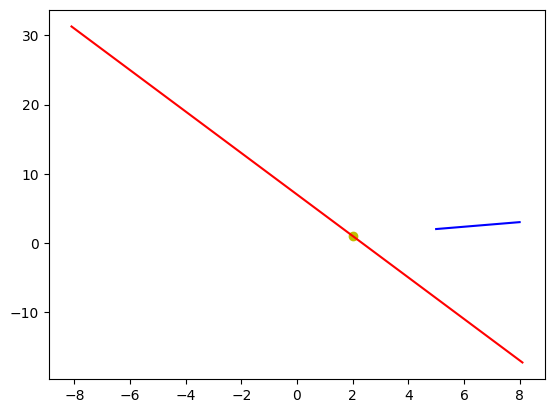

In [22]:
p0 = Point(1.9999963795435443,0.999994640083903,shake=0)
p1 = Point(5.000001760804929,1.9999966583671591,shake=0)
p2 = Point(8.000003952213047,2.999991979966869,shake=0)
SegFromPointToSegDev(p0,Segment(p1,p2))

## Display

## Testing

In [23]:
Point.Reset()
p1 = Point(1,0, shake=0)
p2 = Point(0,2, shake=0)
p3 = Point(2,2, shake=0)
Point.Reset()
polar_set = SortedDict()      #Points are being sorted according to polar coordinate
polar_set[p1] = None
polar_set[p2] = None
polar_set[p3] = None
for key in polar_set.keys():
    print(key)

1: 1.0   0.0
3: 2.0   2.0
2: 0.0   2.0


In [24]:
Point.Reset()
p1 = Point(1,0, shake=0)
p2 = Point(0,2, shake=0)
p3 = Point(2,2, shake=0)
p4 = Point(2,3, shake=0)
p5 = Point(1.5,3, shake=0)
p6 = Point(0.003,3, shake=0)
Point.Reset()
xc_set = SortedDict(X_Coord)      #Points are being sorted according to x coordinate
xc_set[p1] = None
xc_set[p2] = None
xc_set[p3] = None
xc_set[p4] = None
xc_set[p5] = None
xc_set[p6] = None
for key in xc_set.keys():
    print(key)

2: 0.0   2.0
6: 0.003   3.0
1: 1.0   0.0
5: 1.5   3.0
3: 2.0   2.0
4: 2.0   3.0


In [25]:
Segment.Reset()
Point.Reset()
p1 = Point(-1,0)
p2 = Point(1,0)
p3 = Point(-2,1)
p4 = Point(2,1)
p5 = Point(0,3)
pentagon = SortedDict()
pentagon[p1] = None
pentagon[p2] = None
pentagon[p3] = None
pentagon[p4] = None
pentagon[p5] = None
pentagon_seg = GetSegments(pentagon)       #working
for k in pentagon_seg.keys():
    if pentagon_seg[k][1]==0:
        print(pentagon_seg[k][0])
    print("\n")

Id: 5
Begin: -1.9999894352693501   0.9999874311810832
End: -1.000000311731418   -8.770654400586084e-07


Id: 4
Begin: -1.999986023689239   0.9999932627247717
End: -6.224736014087226e-06   2.9999982851511637




Id: 1
Begin: -0.999994596298438   3.0161685293285045e-07
End: 0.9999998547403526   -1.5221484700326217e-05




Id: 3
Begin: -2.1846515523348525e-06   2.999991251141283
End: 1.9999908254607617   1.000019553463214




Id: 2
Begin: 1.0000114454146036   -2.993207384207429e-06
End: 1.9999935372379334   1.0000022513188576








In [26]:
Point.Reset()
p1 = Point(0,2)
p2 = Point(3,0)
p3 = Point(3,3)
triangle = SortedDict()
triangle[p1] = None
triangle[p2] = None
triangle[p3] = None
triangle_seg = GetSegments(triangle)
for k in triangle_seg.keys():
    if triangle_seg[k][1]==0:
        print(triangle_seg[k][0])
    print("\n")


Id: 8
Begin: 1.0042549895981299e-05   1.9999946988269484
End: 2.999987377214635   9.548619996972831e-06


Id: 7
Begin: 1.0223821480366475e-05   2.0000059443573046
End: 2.999983202620355   2.999995230082702






Id: 6
Begin: 2.9999875843917394   1.2920022398443484e-05
End: 2.999996192615587   2.9999964756916704






In [27]:
SweepLine(triangle_seg,pentagon_seg)

True

(1.4142144206376759, <__main__.Point at 0x26bcb032fe0>)

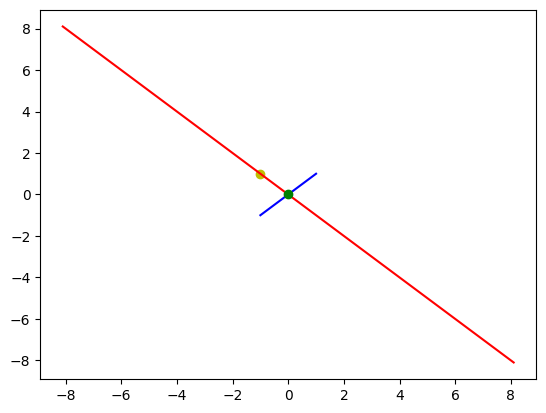

In [28]:
Point.Reset()
p1 = Point(1,1)
p2 = Point(-1,-1)
p0 = Point(-1,1)
s = Segment(p1,p2)
SegFromPointToSegDev(p0, s)

Pentagon:
1: -0.9999963005800746   6.442132146213712e-06
2: 1.0000096538091257   -9.031326623409296e-06
4: 2.000001186203466   0.9999961632342471
5: -6.940386327735902e-06   2.9999921830108116
3: -2.0000057288890423   0.9999923869454205
Another triangle:
7: 8.000007345379268   9.611993140414347e-06
8: 8.00000292488106   3.000006791839545
6: 4.999991008228451   2.00000752713986
closest points: 
Point from hull 0
4: 2.000001186203466   0.9999961632342471
Next point
5: -6.940386327735902e-06   2.9999921830108116
distance to the closest of another polygon
inf
Previous point
2: 1.0000096538091257   -9.031326623409296e-06
distance to the closest of another polygon
inf
Point from hull 1
6: 4.999991008228451   2.00000752713986
Next point
7: 8.000007345379268   9.611993140414347e-06
distance to the closest of another polygon
inf
Previous point
8: 8.00000292488106   3.000006791839545
distance to the closest of another polygon
inf
Segment
Id: 5
Begin: 2.000001186203466   0.9999961632342471
End: 4

C:\Users\Gabri\AppData\Local\Temp\ipykernel_18408\2508149221.py:19: DeprecationWarning: sorted_dict.iloc is deprecated. Use SortedDict.keys() instead.
  next_point = hulls[i].iloc[next_point_index]


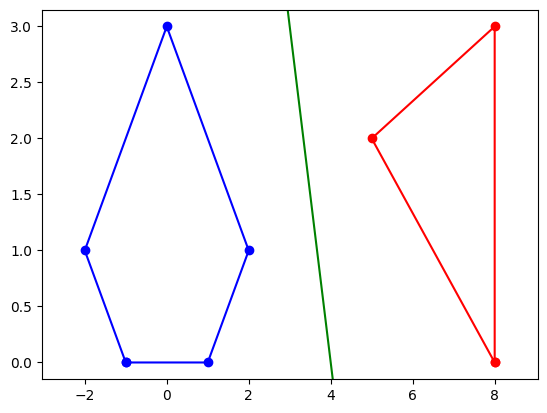

In [29]:
Segment.Reset()
Point.Reset()
p1 = Point(-1,0)
p2 = Point(1,0)
p3 = Point(-2,1)
p4 = Point(2,1)
p5 = Point(0,3)
pentagon = SortedDict()
pentagon[p1] = None
pentagon[p2] = None
pentagon[p3] = None
pentagon[p4] = None
pentagon[p5] = None
p6 = Point(5,2)
p7 = Point(8,0)
p8 = Point(8,3)
another_triangle = SortedDict()
another_triangle[p6] = None
another_triangle[p7] = None
another_triangle[p8] = None
print("Pentagon:")
for k in pentagon.keys():
    print(k)
print("Another triangle:")
for k in another_triangle.keys():
    print(k)
separator = Classificator(pentagon, another_triangle)
another_triangle_seg = GetSegments(another_triangle)
PrintHullsAndSeparator(pentagon, another_triangle,separator)

## Data Load and Modelling

### Obesity Classification(TO-DO)

In [30]:
#Source = https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition
obesity_data = pd.read_csv("./dataSets/ObesityDataSet_raw_and_data_sinthetic.csv")

### Iris Classification (Separable)

In [106]:
iris_data = pd.read_csv("./dataSets/Iris.csv")

In [107]:
iris_data.iloc[:,-1].value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

In [108]:
pca = PCA(2)
data = pca.fit_transform(iris_data.iloc[:,:-1])
label_orig = iris_data.iloc[:,-1]

In [109]:
label = (label_orig != 'Iris-setosa').astype(int)
label.value_counts()

Species
1    100
0     50
Name: count, dtype: int64

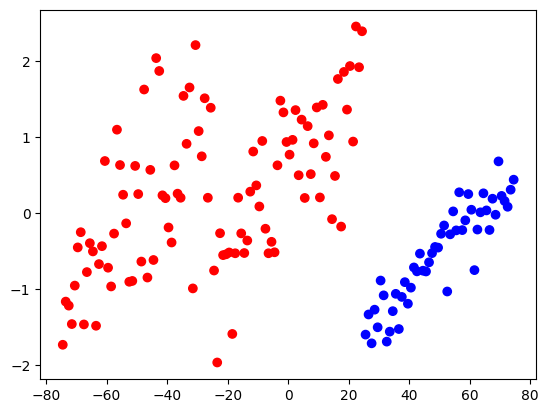

In [110]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1],color=color)
plt.show()

### Spam classification (Non Separable)

In [ ]:
#Source = https://archive.ics.uci.edu/dataset/94/spambase
spambase_data = pd.read_csv("./dataSets/spambase/spambase.data",header=None)
pca = PCA(2)
data = pca.fit_transform(spambase_data.iloc[:,:-1])
label = spambase_data.iloc[:,-1]

In [ ]:
#Duas Classes
label.value_counts()

57
0    2788
1    1813
Name: count, dtype: int64

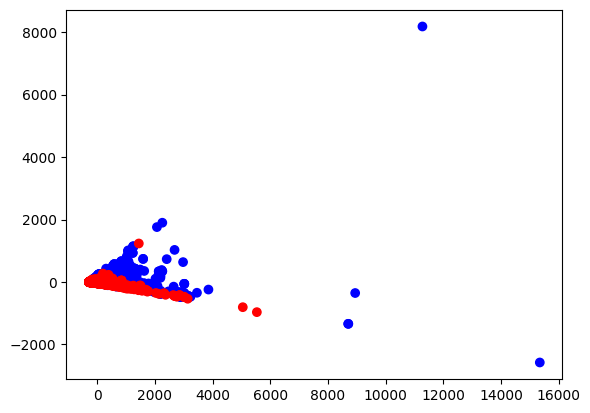

In [ ]:
color = ['red' if l == 0 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1],color=color)

### Haberman (Non Separable)

In [ ]:
#Source = https://archive.ics.uci.edu/dataset/43/haberman+s+survival
haberman = pd.read_csv("./dataSets/haberman+s+survival/haberman.data",header=None)
pca = PCA(2)
data = pca.fit_transform(haberman.iloc[:,:-1])
label = haberman.iloc[:,-1]

In [ ]:
#Duas classes
label.value_counts()

3
1    225
2     81
Name: count, dtype: int64

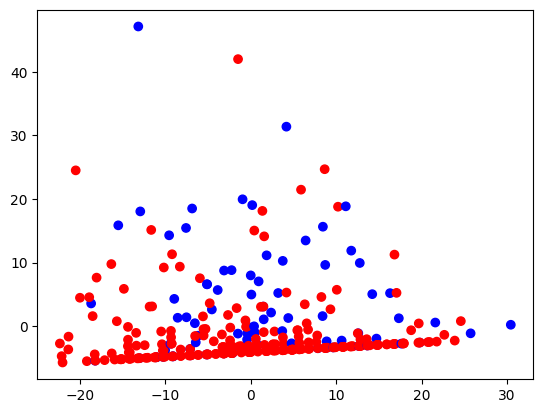

In [ ]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1], color=color)
plt.show()

### Pen Writing Recognition (Non Separable)

In [ ]:
#Source = https://archive.ics.uci.edu/dataset/81/pen+based+recognition+of+handwritten+digits
pen_recog_training = pd.read_csv("./dataSets/pen+based+recognition+of+handwritten+digits/pendigits.tra",header=None)
pen_recog_test = pd.read_csv("./dataSets/pen+based+recognition+of+handwritten+digits/pendigits.tes",header=None)
pen_recog = pd.concat([pen_recog_training,pen_recog_test],axis=0)

In [ ]:
pca = PCA(2)
data = pca.fit_transform(pen_recog.iloc[:,:-1])
label_orig = pen_recog.iloc[:,-1]

In [ ]:
#Dez classes
label_orig.value_counts()

16
2    1144
4    1144
1    1143
0    1143
7    1142
6    1056
8    1055
5    1055
9    1055
3    1055
Name: count, dtype: int64

In [ ]:
#Convertida para duas (Se o dígito escrito for menor que 5)
label = (label_orig < 9).astype(int)
label.value_counts()

16
1    9937
0    1055
Name: count, dtype: int64

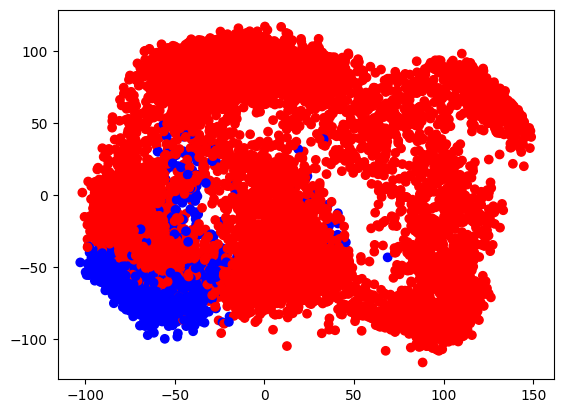

In [ ]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1], color=color)
plt.show()

### Magic

In [75]:
#Source = https://archive.ics.uci.edu/dataset/110/yeast
#Tive que fazer algumas modificações no arquivo direto no excel para mudar a delimitação do arquivo csv e alinhar algumas linhas que não estavam alinhadas com as colunas
magic = pd.read_csv("./dataSets/tic-tac-toe.prepared.txt",sep=",")

In [76]:
magic.iloc[:,-1].value_counts()

Class
positive    626
negative    332
Name: count, dtype: int64

In [77]:
pca = PCA(2)
data = pca.fit_transform(magic.iloc[:,:-1])
label = magic.iloc[:,-1]

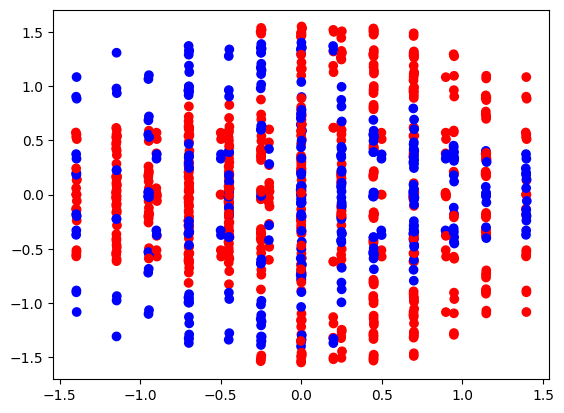

In [78]:
color = ['red' if l == 'positive' else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1],color=color)

### Balance (Separable)

In [151]:
#Source = https://sci2s.ugr.es/keel/dataset.php?cod=54
balance = pd.read_csv("./dataSets/balance.dat.csv",header=None)

In [152]:
balance.iloc[:,-1].value_counts()

4
 R    288
 L    288
 B     49
Name: count, dtype: int64

In [153]:
pca = PCA(2)
data = pca.fit_transform(balance.iloc[:,:-1])
label_orig = balance.iloc[:,-1]

In [157]:
label_orig.value_counts()

4
 R    288
 L    288
 B     49
Name: count, dtype: int64

In [165]:
label = (label_orig != ' L').astype(int)
label.value_counts()

4
1    337
0    288
Name: count, dtype: int64

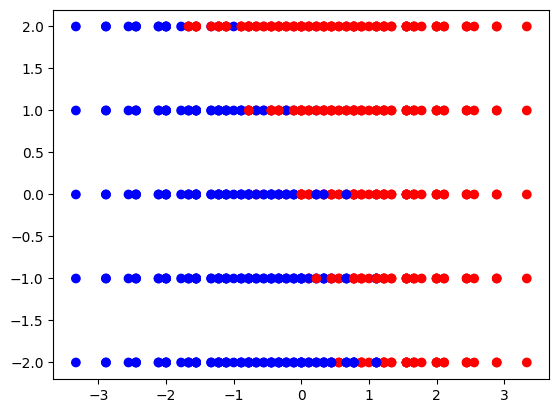

In [166]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1],color=color)
plt.show()

### Hayes Roth (TO-DO)

In [ ]:
#Source = https://sci2s.ugr.es/keel/dataset.php?cod=186
hayes_r = pd.read_csv("./dataSets/hayes-roth.dat",header=None,sep=",")

### Titanic Survival (TO-DO)

In [167]:
#Source = https://sci2s.ugr.es/keel/dataset.php?cod=189
titanic = pd.read_csv("./dataSets/titanic.dat",header=None,sep=",")

In [171]:
titanic

,0,1,2,3
0,-1.8700,-0.228,0.521,-1.0
1,-0.9230,-0.228,-1.920,1.0
2,-0.9230,-0.228,-1.920,1.0
3,0.9650,-0.228,0.521,1.0
4,0.0214,-0.228,0.521,-1.0
...,...,...,...,...
2196,0.9650,-0.228,0.521,-1.0
2197,-0.9230,-0.228,0.521,-1.0
2198,-1.8700,-0.228,0.521,-1.0
2199,0.9650,-0.228,0.521,-1.0


In [169]:
# Retirada a classe 2 para que fique linearmente separável
pca = PCA(2)
data = pca.fit_transform(titanic.iloc[:,:-1])
label = titanic.iloc[:,-1]


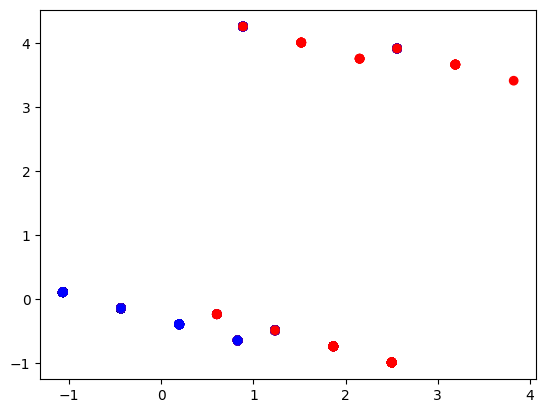

In [173]:
color = ['red' if l == 1 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1], color=color)
plt.show()

### Wine classification

In [63]:
wine = pd.read_csv("./dataSets/wine.prepared.txt",sep=",")

In [101]:
# Retirada a classe 2 para que fique linearmente separável
wine = wine[wine['Class'] != 2]
pca = PCA(2)
data = pca.fit_transform(wine.iloc[:,:-1])
label = wine.iloc[:,-1]

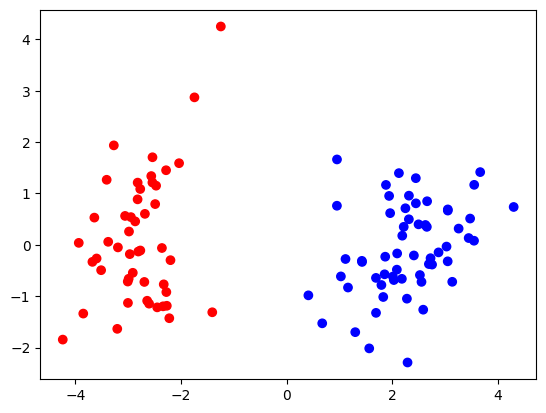

In [102]:
color = ['red' if l == 3 else 'blue' for l in label]
plt.scatter(data[:,0],data[:,1], color=color)
plt.show()

## Model Definition

In [103]:
class Geometric_Classificator:
    def __init__(self):
        self.hulls = list()

    def fit(self, x_train, y_train):
        #Point.Reset()
        #Segment.Reset()
        #Buid the convex hull to each label
        for label in set(y_train):
            set_coord = x_train[y_train == label]
            rbt = SortedDict()
            #Transform all register in the class Point
            set_points = np.apply_along_axis(lambda x: Point(x[0],x[1]), axis = 1, arr = set_coord)
            for p in set_points:
                rbt[PointWrap(p)] = None
            self.hulls.append([label,ConvexHullA(rbt)])
            rbt.clear()
        
        #Apply SweepLine in both Hulls to check for intersections
        hulls_segment = [GetSegments(self.hulls[i][1]) for i in range(2)]
        
        if(SweepLine(hulls_segment[0],hulls_segment[1])):
            print("Data is linear separable")
        else:
            print("Data is not linear separable")
            return False
        
        self.slope, self.intersect = Classificator(self.hulls[0][1], self.hulls[1][1])
        return    

In [111]:
gc = Geometric_Classificator()

In [112]:
gc.fit(data,label)

C:\Users\Gabri\AppData\Local\Temp\ipykernel_18408\1216296178.py:18: DeprecationWarning: sorted_dict.iloc is deprecated. Use SortedDict.keys() instead.
  compare_cclock = polar_hull.iloc[index_cclock_comparable]   #first element to search counter-clockwise the vertex that links to p in the old hull


ValueError: <__main__.Point object at 0x0000026BCF3A2230> is not in list

In [45]:
#hulls_segment = [GetSegments(gc.hulls[l]) for l in gc.hulls.keys()]
#SweepLine(hulls_segment[0],hulls_segment[1])

True

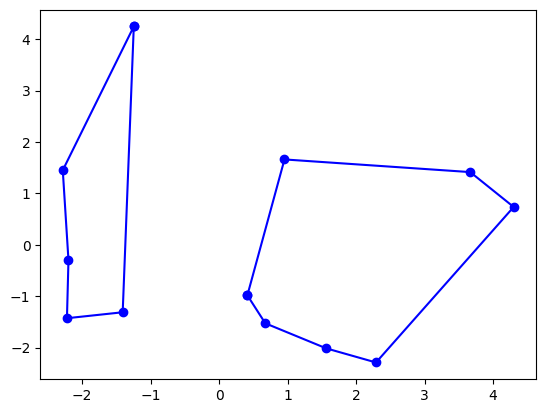

In [98]:
PrintHullA(gc.hulls[0][1])
PrintHullA(gc.hulls[1][1])